In [1]:
import os
import cv2
import numpy as np
from scipy.spatial import distance as dist
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time


## Creating the optimized version of findpeak and meanshift

In [2]:
def findpeak_opt(data, r, c, threshold=0.01):
    """
    Function to find peaks using an optimized version of the mean shift algorithm.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition.

    Returns:
    - peaks: NumPy array containing the found peaks.
    - labels: NumPy array of shape (N,) containing the assigned label for each data point.
    """

    peaks = []  # List to store the found peaks
    labels = np.full(len(data), -1)  # Array to store the assigned label for each data point (-1 indicates unassigned)

    # Iterate over each data point
    for count, p in enumerate(data):
        if labels[count] == -1:
            add_pixels = np.zeros(len(data))  # Array to track points within the adjusted radius
            shift = 5  # Initialize the shift value (greater than the threshold)

            while shift > threshold:
                # Calculate distances from the current point to all other points
                dist_pixel = cdist([p], data)[0]

                # Select points within the specified radius and the adjusted radius
                window = data[dist_pixel < r]
                add_pixels[dist_pixel < r / c] = 1

                # Calculate the center of mass within the window
                center_mass = window.mean(axis=0)

                # Calculate the shift between the current point and the center of mass
                shift = dist.euclidean(p, center_mass)

                # Update the current point to the center of mass
                p = center_mass

            if len(peaks) == 0:
                # If no peaks exist, add the center of mass as a new peak
                peaks.append(center_mass)
                labels[cdist([center_mass], data)[0] < r] = len(peaks) - 1
                labels[add_pixels == 1] = len(peaks) - 1
                continue

            # Check if the center of mass is close to any existing peaks
            distances = cdist([center_mass], peaks)

            if distances.min() > r / 2:
                # If not close to any existing peaks, add the center of mass as a new peak
                peaks.append(center_mass)
                labels[cdist([center_mass], data)[0] < r] = len(peaks) - 1
                labels[add_pixels == 1] = len(peaks) - 1
            else:
                # If close to an existing peak, assign the label of the closest peak
                labels[count] = distances.argmin()
                labels[add_pixels == 1] = distances.argmin()
        else:
            continue

    return np.array(peaks), labels


def meanshift_opt(data, peaks, r, c, threshold=0.01):
    """
    Function to perform mean shift clustering using optimized peak shifting.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - peaks: NumPy array containing the initial peaks.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition. Should never be higher than 5!

    Returns:
    - shifted_peaks: NumPy array containing the shifted peaks.
    """

    shifted_peaks = []  # List to store the shifted peaks

    # Iterate over each peak
    for p in peaks:
        shift = 5  # Initialize the shift value (greater than the threshold)

        while shift > threshold:
            # Calculate distances from the current peak to all data points
            distances = dist.cdist([p], data)[0]

            # Select points within the specified radius
            window = data[distances < r]

            # Calculate the center of mass within the window
            center_mass = window.mean(axis=0)

            # Calculate the shift between the current peak and the center of mass
            shift = dist.euclidean(p, center_mass)

            # Update the current peak to the center of mass
            p = center_mass

        shifted_peaks.append(center_mass)

    return np.array(shifted_peaks)


In [3]:
def segmIm(path_img, r, c, threshold=0.01, add_pos=True):
    """
    Function to perform image segmentation using Mean Shift algorithm.

    Parameters:
    - img: NumPy array representing the input image.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition.
    - add_pos: Boolean flag to specify whether to add positional information to the feature vector.

    Returns:
    - peaks: NumPy array containing the found peaks.
    - labels: NumPy array of shape (N,) containing the assigned label for each data point.
    - rec_img: NumPy array representing the segmented image.
    """

    # First, we implement some preprocessing steps for the image used

    # Used for plotting in the end
    input_img = cv2.imread(path_img)
    original_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2BGR)
    #orig_img = original_img.astype(np.float32)/255.0

    # Used for mean shift
    img = cv2.cvtColor(input_img, cv2.COLOR_RGB2LAB)
    #img = image.astype(np.float32)/255.0
    shape = img.shape

    # Add positional information to feature vector
    if add_pos:
        indices = np.ones((img.shape[0], img.shape[1], 2))
        row, column = np.indices(img.shape[0:2])
        indices[:, :, 0] = row
        indices[:, :, 1] = column
        img = np.append(img, indices, axis=2)
        img = img.reshape(-1, img.shape[-1])
        marker_5D = '5D'
    else:
        img = img.reshape(-1, img.shape[-1])
        marker_5D = ''

    # Call findpeak_opt and meanshift_opt functions
    peaks, labels = findpeak_opt(img, r, c, threshold)
    shifted_peaks = meanshift_opt(img, peaks, r, c)

    # Reconstruct image from shifted peaks and labels
    rec_img = np.zeros(shape, dtype="uint8")
    rec_img = rec_img.reshape(-1, 3)
    for unique in np.unique(labels):
        rec_img[labels == unique] = shifted_peaks[unique][0:3]
    rec_img = rec_img.reshape(shape)
    rec_img = cv2.cvtColor(rec_img, cv2.COLOR_LAB2BGR)

    # Plot image
    f, ax = plt.subplots(1, 2, figsize=(12, 8))
    ax[0].imshow(original_img)
    ax[0].set_title("Original")
    ax[1].imshow(rec_img)
    ax[1].set_title("Segmented")
    
    # Extract the file name from the input path
    num_segments = len(np.unique(labels)) # number of segments in the image
    file_name = os.path.splitext(os.path.basename(path_img))[0]  # Extract the file name without extension
    params = f"_r={r}_c={c}_threshold={threshold}_segments={num_segments}"  # Parameters for the title
    save_path = f"{file_name}{params}{marker_5D}.png"  # Save path for the segmented image
    plt.savefig(save_path)


    return peaks, labels, rec_img



In [4]:
path_img_1 = 'img_1.jpg'
path_img_2 = 'img_2.jpg'
path_img_3 = 'img_3.jpg'

img_1 = cv2.imread(path_img_1)
img_2 = cv2.imread(path_img_2)
img_3 = cv2.imread(path_img_3)

img_list = [path_img_1, path_img_2, path_img_3]


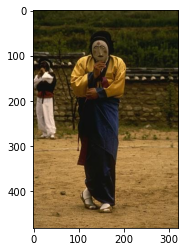

In [5]:
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))


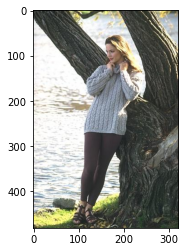

In [6]:
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))


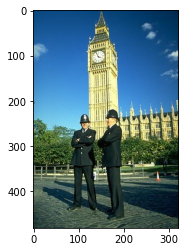

In [7]:
plt.imshow(cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB))


In [8]:
r = 20
c = 4
threshold = 0.01


time necessary: img_1.jpg  25.741475820541382
time necessary: img_2.jpg  55.809160470962524
time necessary: img_3.jpg  185.89128160476685


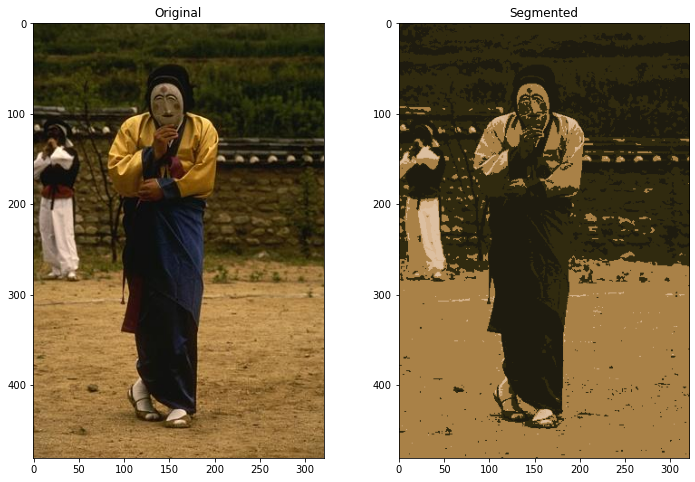

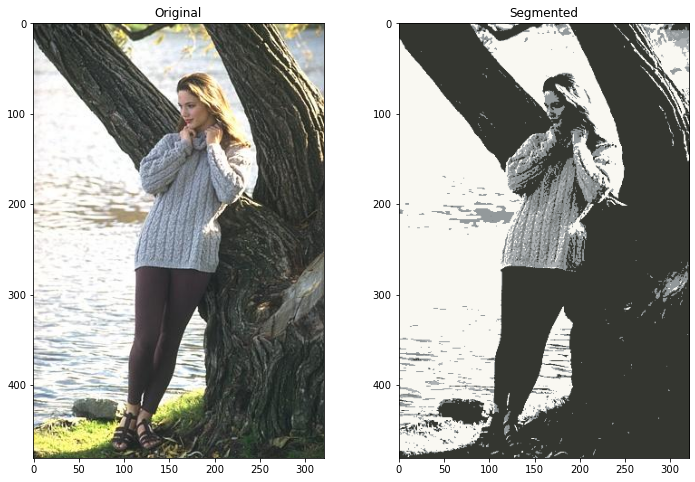

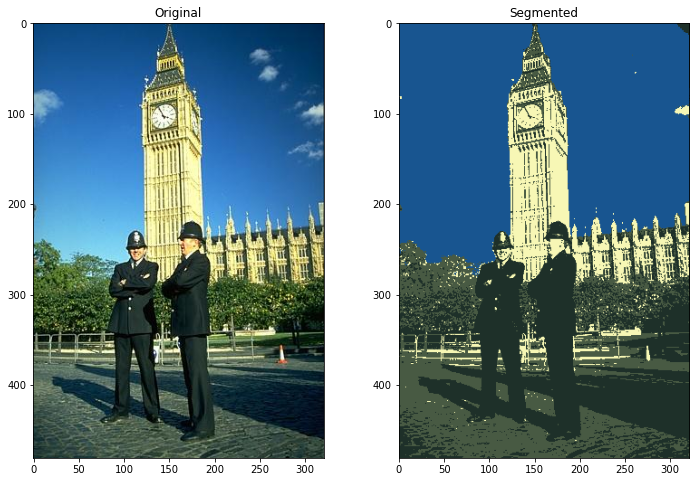

In [9]:
for img in img_list:
    start = time.time()
    peaks,labels, rec_img  =segmIm(img, r, c, threshold, False)
    end = time.time()
    print(f'time necessary: {img} ', end-start)
    

time necessary:  1101.450380563736
time necessary:  2364.3337907791138
time necessary:  1800.4815816879272


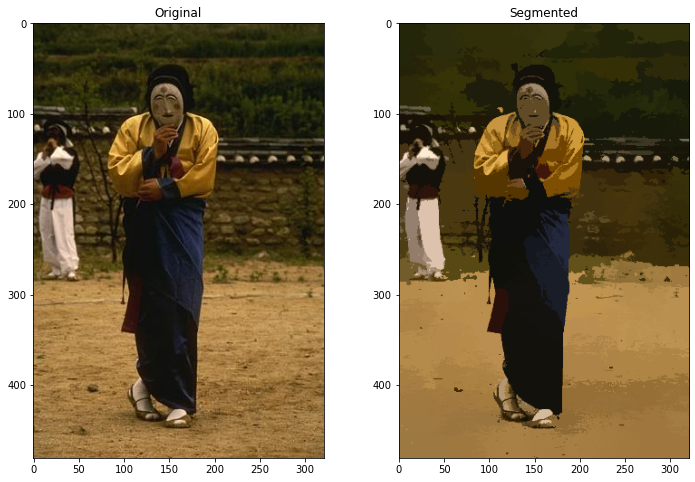

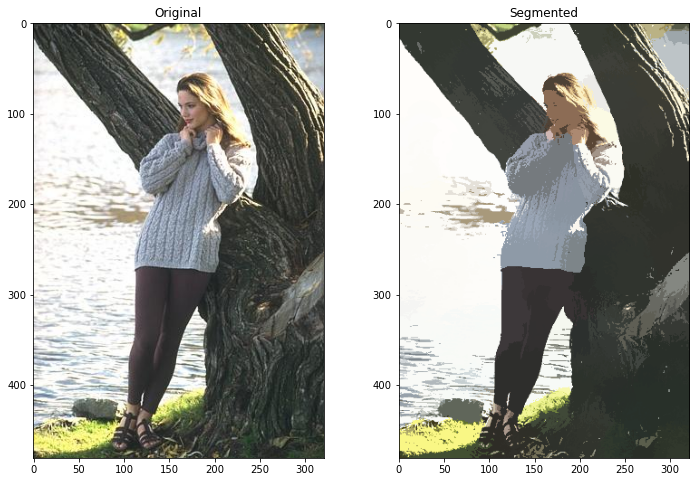

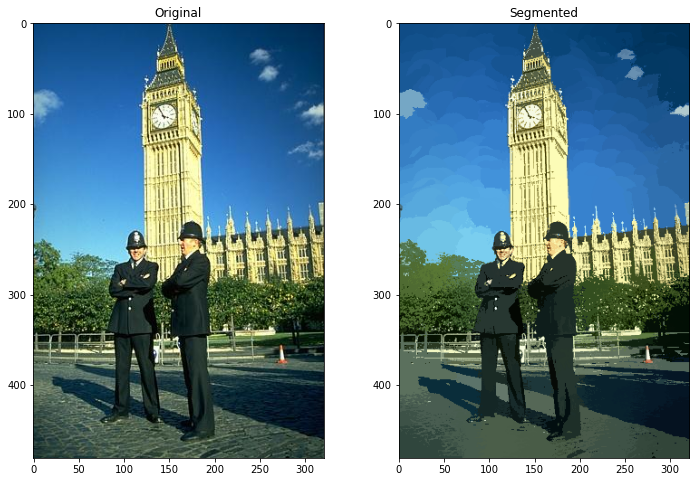

In [10]:
for img in img_list:
    start = time.time()
    peaks,labels, rec_img  =segmIm(img, r, c, threshold, True)
    end = time.time()
    print('time necessary: ', end-start)